In [1]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [2]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [3]:
hdf_dir = Path("../data")

In [66]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [118]:
fname = "2021_5_21.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<80} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1621621029 scan R0 F=1 F1'=1_2                                                   : 1001
1  <> 1621621953 scan P2 F1 with R0 F=1 F1'=1_2 DET                                    : 26
2  <> 1621621988 scan P2 F1 with R0 F=1 F1'=1_2 DET                                    : 236
3  <> 1621622124 scan P2 F1 with R0 F=1 F1'=1_2 DET                                    : 246
4  <> 1621622314 scan P2 F1 with R0 F=1 F1'=1_2 DET                                    : 681
5  <> 1621622911 scan P2 F1 ratio with R0 F=1 F1'=1_2 DET                              : 2041
6  <> 1621623740 scan J12 power P2 F1 ratio with R0 F=1 F1'=1_2 DET                    : 3001
7  <> 1621624683 scan Q1 DET                                                           : 916
8  <> 1621625295 scan J12 power P2 F1 ratio with Q1 F=1 F1'=1_2 DET                    : 101
9  <> 1621625411 scan J12 power P2 F1 ratio with Q1 F=1 F1'=1_2 DET                    : 3001
10 <> 1621627277 scan R2 F=4 F1'=7_2                               

### Detection laser beam is passed through the detection region twice, and then retroflected (going through a $\lambda/4$) for another two passes. Laser is elliptically expanded in height.

### All with phase modulation on detection

## Scan R0 F=1 F1'=1/2
50 mW

In [6]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [15]:
dset_idx = 0
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

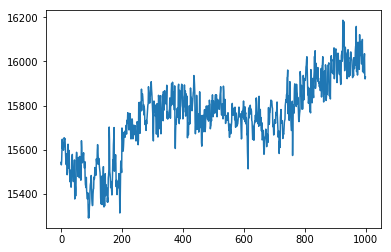

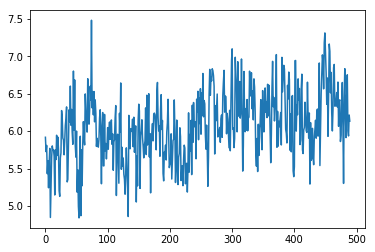

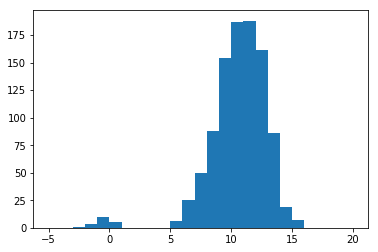

In [16]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [17]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [18]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

1.9% data discarded


In [19]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

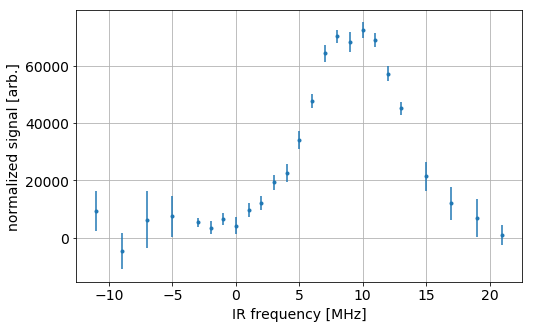

In [20]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [21]:
stat.max()

72674.33915666466

## Scan P2 F1
80 mW

In [83]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [84]:
dset_idx = 3
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

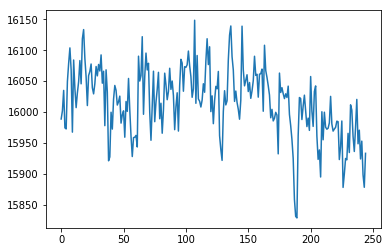

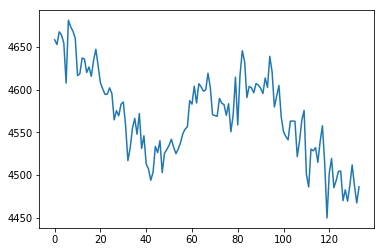

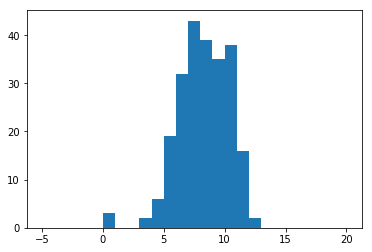

In [85]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [86]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [87]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

4.9% data discarded


In [88]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

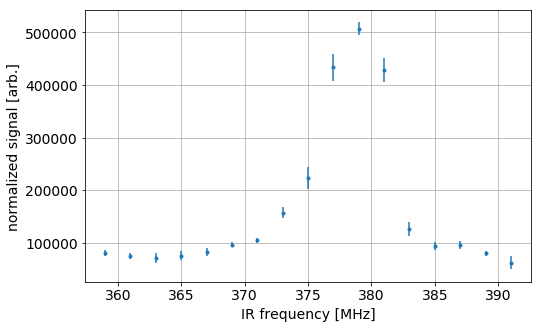

In [89]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan P2 F1
80 mW
Set ADC to 1V (from 0.4V) to prevent overflow 

In [44]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [45]:
dset_idx = 4
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

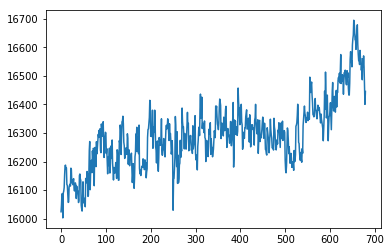

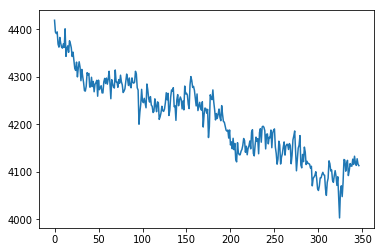

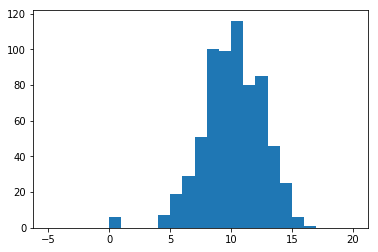

In [46]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [47]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [48]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

1.9% data discarded


In [49]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

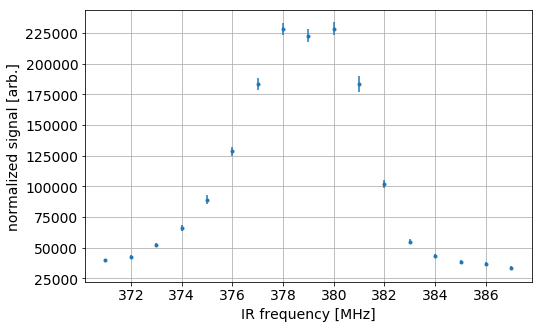

In [50]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan P2 F1 ratio with R0 F1 DET

In [66]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [75]:
dset_idx = 5
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

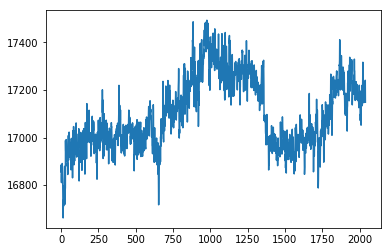

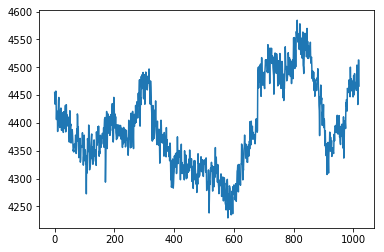

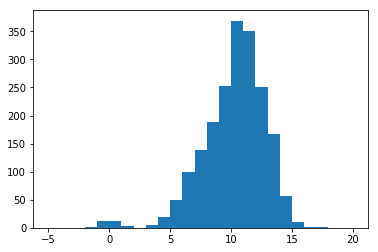

In [76]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [77]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 4600

In [78]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

2.8% data discarded


In [79]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

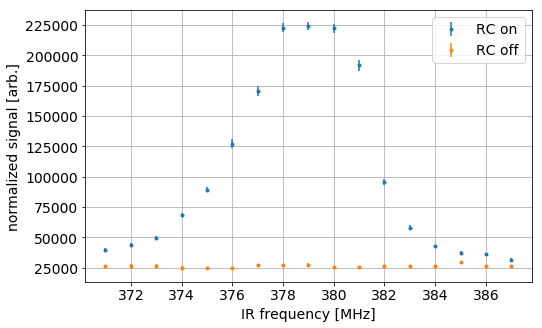

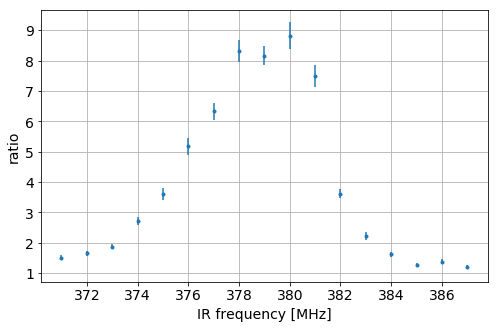

In [80]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan J12 Power P2 F1 ratio with R1 F1 DET

In [127]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [128]:
dset_idx = 6
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

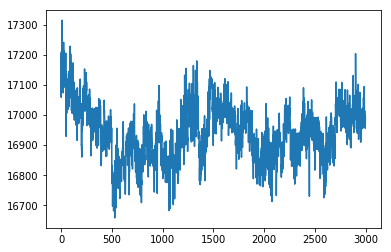

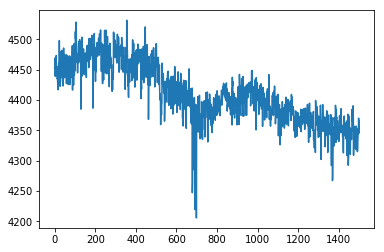

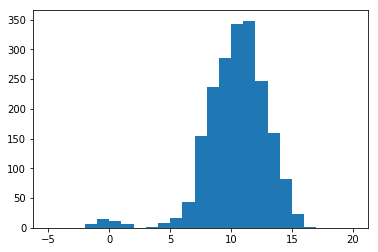

In [129]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [130]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 4600

In [131]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

2.3% data discarded


In [132]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

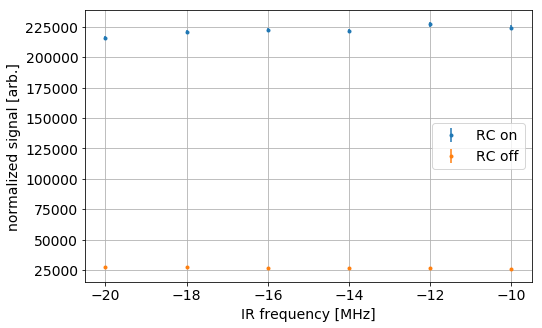

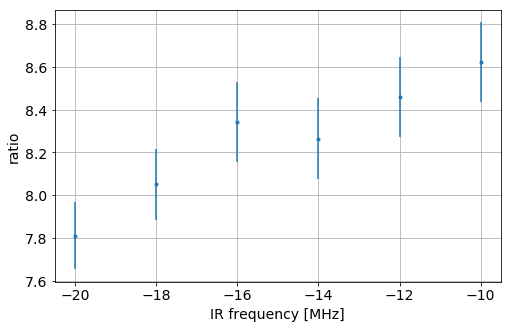

In [133]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

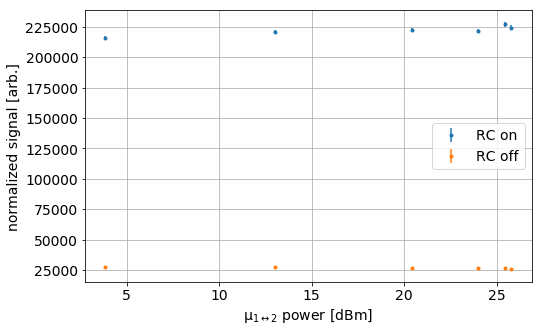

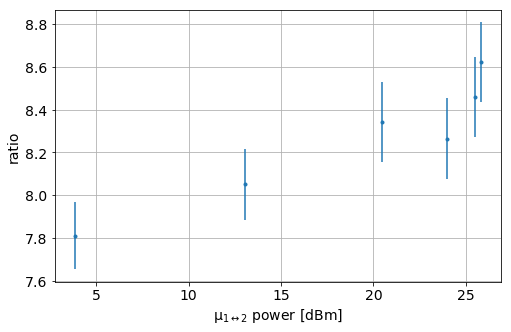

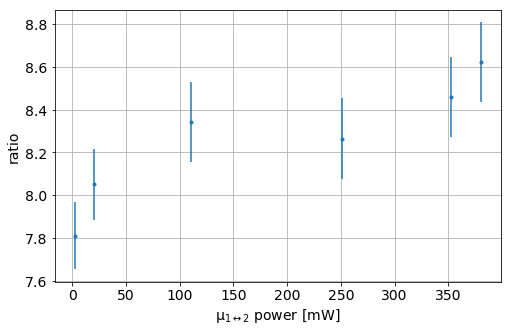

In [143]:
powers = {-10: -7.2 + 33,
          -12: -7.53 + 33, 
          -14: -9 + 33,
          -16: -12.55 + 33,
          -18: -19.96 + 33,
          -20: -29.15 + 33
         }

conv_dBm_mW = lambda x: 10**(x/10)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar([powers[bm] for bm in bin_means], results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar([powers[bm] for bm in bin_means], results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel(r'μ$_{1\leftrightarrow 2}$ power [dBm]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar([powers[bm] for bm in bin_means], ratio, yerr = err, fmt = '.')

ax.set_xlabel(r'μ$_{1\leftrightarrow 2}$ power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)


fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar([conv_dBm_mW(powers[bm]) for bm in bin_means], ratio, yerr = err, fmt = '.')

ax.set_xlabel(r'μ$_{1\leftrightarrow 2}$ power [mW]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan Q1 F1'=1/2 F=1

In [134]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [122]:
dset_idx = 7
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

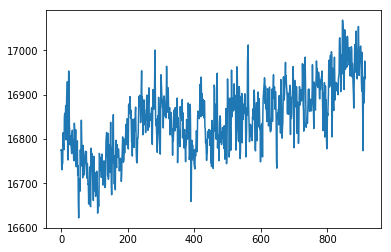

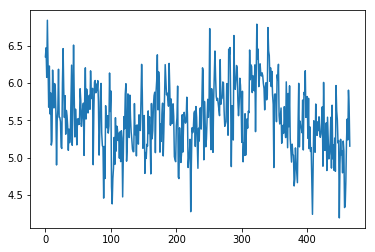

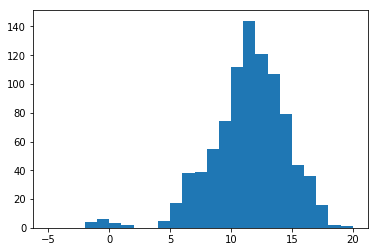

In [123]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [124]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [125]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

2.2% data discarded


In [126]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

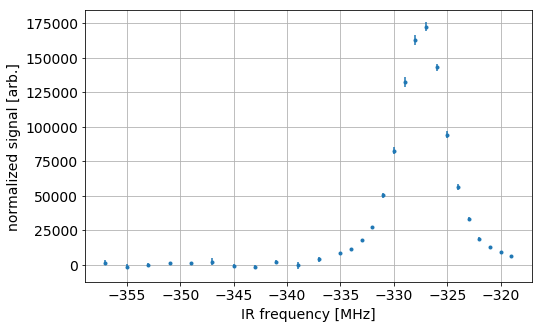

In [127]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

In [128]:
stat.max()

172387.28094689676

## Scan J12 Power P2 F1 ratio with Q1 DET

In [14]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [25]:
dset_idx = 9
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

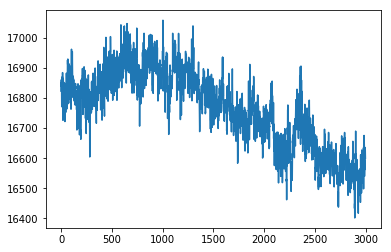

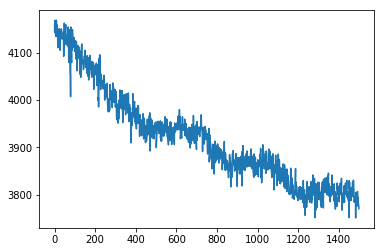

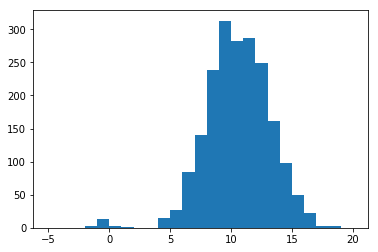

In [26]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [27]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 4600

In [28]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

1.9% data discarded


In [29]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

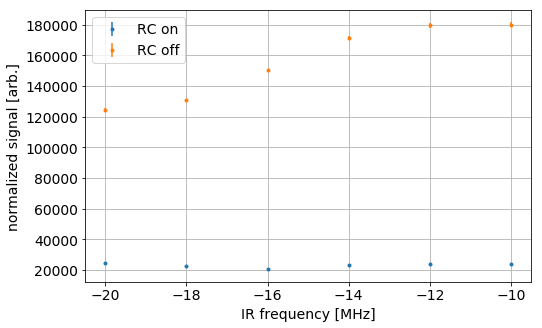

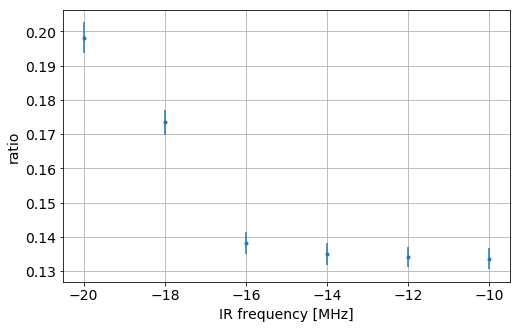

In [30]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan R2 F=4 F1'=7/2

In [121]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [52]:
dset_idx = 10
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

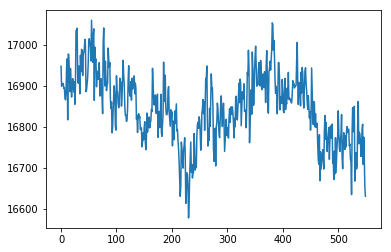

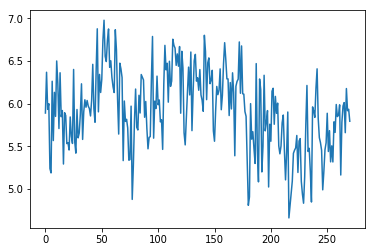

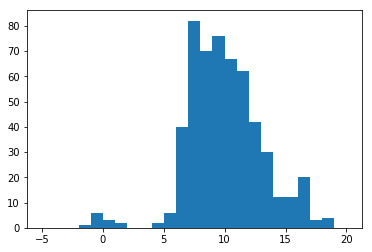

In [53]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [54]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [55]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

2.5% data discarded


In [56]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

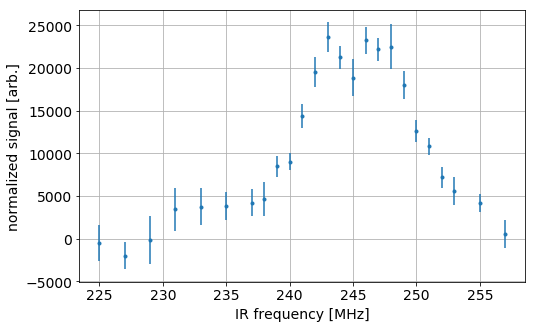

In [57]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan P2 F1 ratio with R2 F=4 F1'=7/2
35 mW DET  
75 mW RC  
microwaves at low power

In [66]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [59]:
dset_idx = 11
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

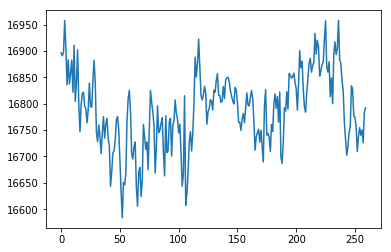

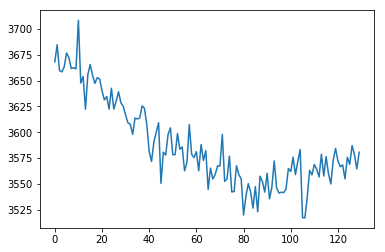

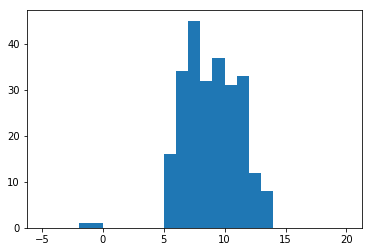

In [60]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [61]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 4600

In [62]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

0.8% data discarded


In [63]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

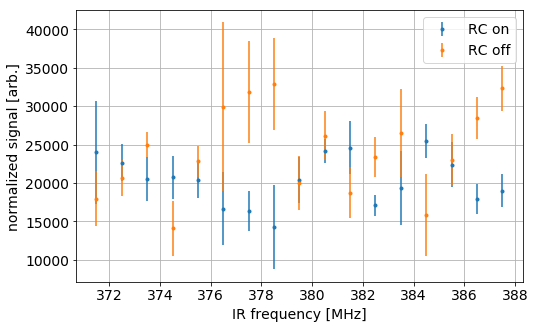

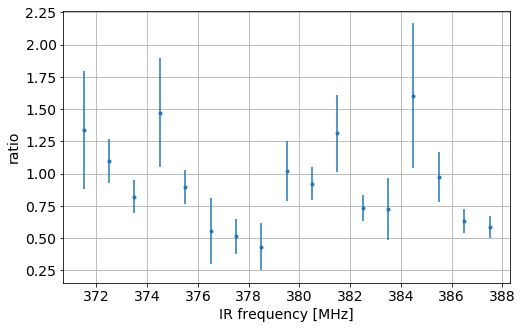

In [64]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan P2 F1 ratio with R2 F=4 F1'=7/2
35 mW DET  
75 mW RC  
microwaves at normal power

In [91]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [92]:
dset_idx = 12
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

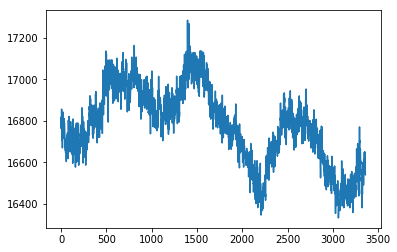

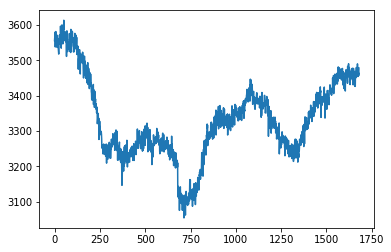

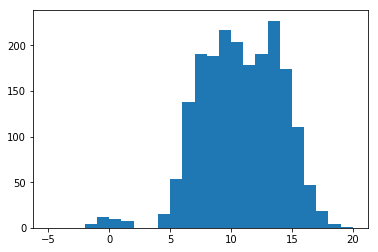

In [93]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [94]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 4600

In [95]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

2.7% data discarded


In [96]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

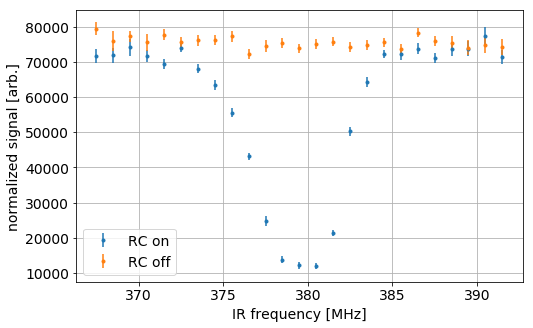

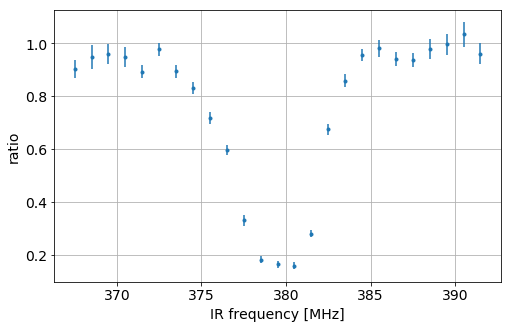

In [97]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan J12 Power P2 F1 ratio with F=4 F1'=7/2 DET

In [102]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [103]:
dset_idx = 14
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

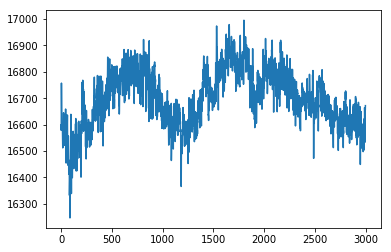

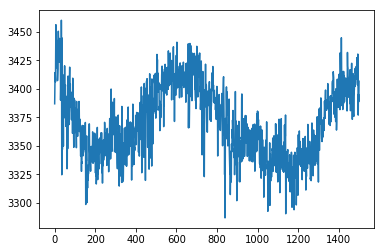

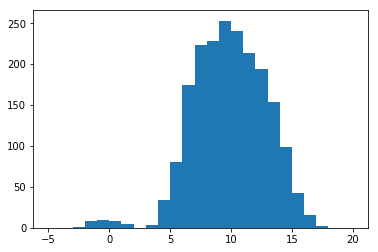

In [104]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [105]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 4600

In [106]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

5.9% data discarded


In [107]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

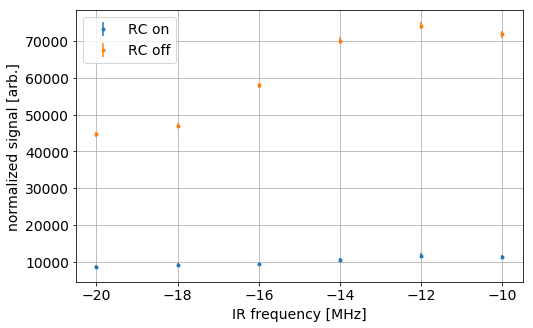

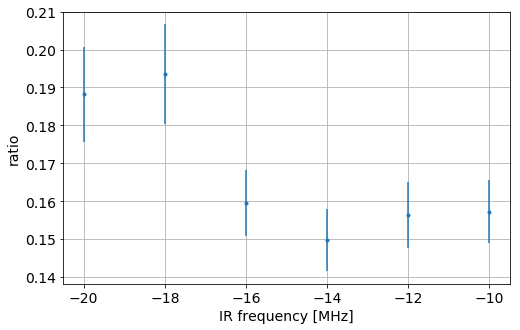

In [108]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Scan R3 F=5 F1'=9/2

In [121]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [111]:
dset_idx = 15
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed2'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

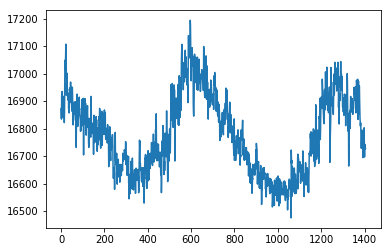

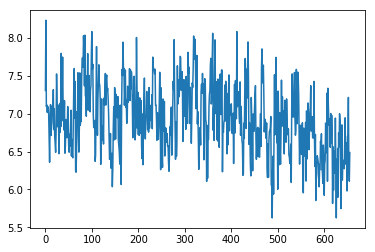

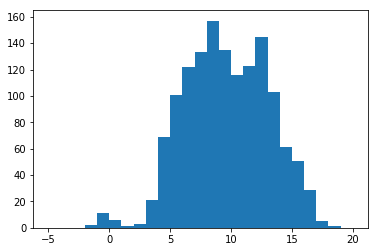

In [112]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [113]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6

In [114]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

8.1% data discarded


In [115]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

stat = []
err = []
for f in np.unique(scan_parameters):
    mask_frequency = scan_parameters == f
    mt = mask_frequency
    dat = (fluorescence_integral/absorption_integral)[mt]
    stat.append(np.nanmean(dat))
    err.append(np.nanstd(dat)/np.sqrt(np.sum(~np.isnan(dat))-1))
stat = np.array(stat)
err = np.array(err)
    
bin_means = np.unique(scan_parameters)

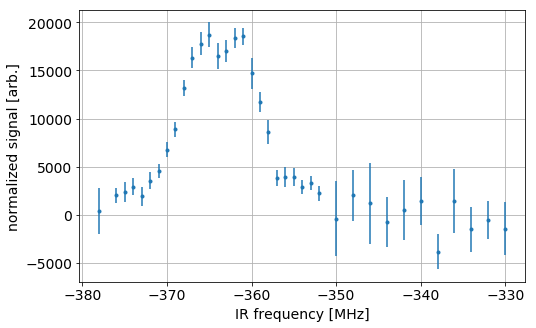

In [116]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)
set_fontsize(ax, 14)

## Scan P2 F1 ratio with R3 F=5 F1'=9/2
36 mW DET  
77 mW RC  
microwaves at normal power

In [120]:
slice_flm  = np.s_[-3000:]
slice_absm = np.s_[-3000:]
slice_fli  = np.s_[150:]
slice_absi = np.s_[10:2000]

In [121]:
dset_idx = 16
dnames = [dset_names[dset_idx]]
devices = ('ZaberTMM',)
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dnames[0], devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

for dname in dnames[1:]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dname, devices)

    yag_data = np.append(yag_data, np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)]), axis = 0)
    pmt_data = np.append(pmt_data, -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pd_data = np.append(pd_data, np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdn_data = np.append(pdn_data, np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    shutter_data = np.append(shutter_data, np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    pdrc_data = np.append(pdrc_data, np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)]), axis = 0)
    scan_parameters = np.append(scan_parameters, np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)]), axis = 0)

norm_data = -pd_data/pdn_data

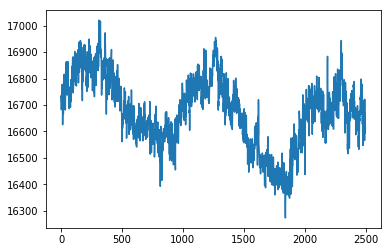

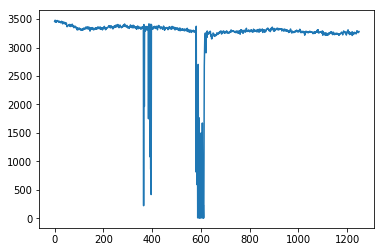

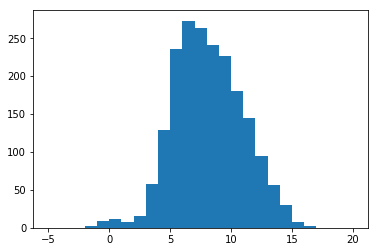

In [122]:
plt.plot(pdn_data.mean(axis = 1))
plt.figure()
plt.plot(pdrc_data.mean(axis = 1)[shutter_data.max(axis = 1) > 10000])

_ = norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]
m = ~(np.isinf(_[:,0]) | np.isnan(_[:,0]))
_ = _[m]
plt.figure()
plt.hist(np.trapz(_[slice_absi]), bins = np.linspace(-5,20,26));

In [123]:
yag_cutoff = 250
ptn_cutoff = 6000
abs_cutoff = 5
fl_cutoff = -1e6
pdrc_cutoff = 4600

In [124]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff
mask_pdrc_sho = (pdrc_data.min(axis = 1) < 1500) & (shutter_data.max(axis = 1) > 10000)
mask_pdrc_shc = (pdrc_data.min(axis = 1) > 1500) & (shutter_data.max(axis = 1) < 10000)

mask = mask_yag | mask_pdn | mask_abs | mask_fl | mask_pdrc_sho | mask_pdrc_shc

print(f"{mask.sum()/len(mask)*100:.1f}% data discarded")

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

12.0% data discarded


In [125]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt((~np.isnan(dat)).sum()-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

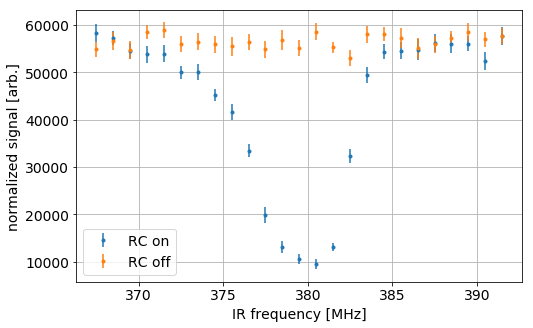

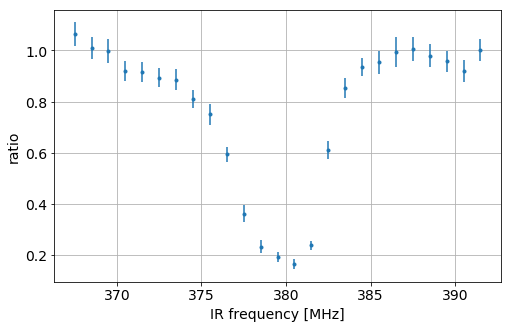

In [126]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)